<a href="https://colab.research.google.com/github/nando-cezar/mcer/blob/main/mcer_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MCER


###IMPORTING LIBRARIES

In [ ]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests
!pip install pandas matplotlib seaborn numpy geopandas
!pip install --upgrade matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np

from google.colab import drive
from google.colab import userdata

import requests_cache
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import openmeteo_requests
import requests

###CONFIGURAÇÃO DA API OPEN-METEO

In [ ]:
# ---------------------------
# CONFIGURAÇÃO DA API OPEN-METEO
# ---------------------------

# Configuração de cache e retry
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_strategy = Retry(
    total=5,  # Número máximo de tentativas
    backoff_factor=0.2,  # Fator de espera exponencial entre tentativas
    status_forcelist=[500, 502, 503, 504]  # Códigos de status para retry
)
cache_session.mount('https://', HTTPAdapter(max_retries=retry_strategy))
openmeteo = openmeteo_requests.Client(session=cache_session)

# Função para buscar dados climáticos
def search_info_weather(latitude, longitude, start_date, end_date, timezone):
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "temperature_2m_mean",
            "apparent_temperature_max",
            "apparent_temperature_min",
            "apparent_temperature_mean",
            "daylight_duration",
            "sunshine_duration",
            "precipitation_sum",
            "rain_sum",
            "snowfall_sum",
            "precipitation_hours",
            "wind_speed_10m_max",
            "wind_gusts_10m_max",
            "wind_direction_10m_dominant",
            "shortwave_radiation_sum",
            "et0_fao_evapotranspiration"
        ],
        "timezone": timezone,
    }
    responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)
    response = responses[0]
    daily = response.Daily()
    variables = [daily.Variables(i).ValuesAsNumpy() for i in range(17)]
    variable_names = [
        "temperature_2m_max",
        "temperature_2m_min",
        "temperature_2m_mean",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "apparent_temperature_mean",
        "daylight_duration",
        "sunshine_duration",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "wind_speed_10m_max",
        "wind_gusts_10m_max",
        "wind_direction_10m_dominant",
        "shortwave_radiation_sum",
        "et0_fao_evapotranspiration"
    ]
    daily_data = {"date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s"),
        end=pd.to_datetime(daily.TimeEnd(), unit="s"),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )}
    daily_data["latitude"] = response.Latitude()
    daily_data["longitude"] = response.Longitude()
    for name, values in zip(variable_names, variables):
        daily_data[name] = values
    return daily_data

###DADOS TÉCNICOS DOS EQUIPAMENTOS

In [ ]:
# ---------------------------
# DADOS TÉCNICOS DOS EQUIPAMENTOS
# ---------------------------

# Canadian Solar CS6K-300M
PAINEL_SOLAR = {
    "potencia_kwp": 0.3,               # 0.3kW por painel
    "temperatura_referencia": 25.0,    # Temperatura de referência para eficiência máxima (em °C)
    "eficiencia": 0.18,                # 18%
    "coef_temperatura": -0.0034,       # -0.34%/°C
    "custo_instalacao": 133_000,       # R$ 133 mil (exemplo)
    "vida_util": 25,                   # 25 anos
    "custo_unitario": 3_300,           # R$ 3300 por painel (estimativa)
}

# Bergey Excel 10
TURBINA_EOLICA = {
    "cut_in_speed": 3.0,               # m/s
    "rated_speed": 11.0,               # m/s
    "cut_out_speed": 25.0,             # m/s
    "potencia_nominal": 10,            # 10 kW
    "rotor_area": 38.5,                # m² (Bergey Excel 10)
    "custo_instalacao": 205_000,       # R$ 205 mil (exemplo)
    "vida_util": 20,                   # 20 anos
    "custo_unitario": 205_000,         # R$ 205.000 por turbina (estimativa)
}

###ENERGIA GASTA PARA CONSTRUIR, OPERAR E MANTER OS SISTEMAS

In [ ]:
# ---------------------------
# ENERGIA GASTA PARA CONSTRUIR, OPERAR E MANTER OS SISTEMAS
# ---------------------------

def calcular_energia_gasta_solar():
    """
    Calcula a energia gasta para construir, operar e manter o sistema solar.
    """
    # Energia gasta para energia solar (em kWh)
    energia_gasta = (
        2500 * PAINEL_SOLAR["potencia_kwp"] * PAINEL_SOLAR["quantidade_paineis"] +  # Fabricação dos painéis
        500 * PAINEL_SOLAR["potencia_kwp"] * PAINEL_SOLAR["quantidade_paineis"]     # Instalação e manutenção
    )
    return energia_gasta

def calcular_energia_gasta_eolica():
    """
    Calcula a energia gasta para construir, operar e manter o sistema eólico.
    """
    # Energia gasta para energia eólica (em kWh)
    energia_gasta = (
        5000 * TURBINA_EOLICA["potencia_nominal"] * TURBINA_EOLICA["quantidade_turbinas"] +  # Fabricação das turbinas
        1000 * TURBINA_EOLICA["potencia_nominal"] * TURBINA_EOLICA["quantidade_turbinas"]    # Instalação e manutenção
    )
    return energia_gasta

###CÁLCULOS DE ENERGIA SOLAR


In [ ]:
# ---------------------------
# CÁLCULOS DE ENERGIA SOLAR
# ---------------------------

def calcular_energia_solar(daily_data):
    """
    Calcula a energia gerada por um sistema solar fotovoltaico, garantindo que:
    - A eficiência ajustada pela temperatura nunca seja negativa.
    - As perdas por sujeira não ultrapassem um limite máximo.
    """
    df = pd.DataFrame(daily_data)

    # 1. Converter durações para horas
    df["daylight_hours"] = df["daylight_duration"].replace(0, 1e-6) / 3600
    df["sunshine_hours"] = df["sunshine_duration"].replace(0, 1e-6) / 3600

    # 2. Calcular clearness index (kt) com limite máximo de 1.0
    df["kt"] = df["sunshine_hours"] / df["daylight_hours"]
    df["kt"] = df["kt"].clip(upper=1.0)  # kt não pode ser maior que 100%

    # 3. Irradiação efetiva (ajustada por nebulosidade)
    df["G_eff"] = df["shortwave_radiation_sum"] * 1e-3 * df["kt"]

    # 4. Eficiência ajustada por temperatura (nunca negativa)
    beta = PAINEL_SOLAR["coef_temperatura"]
    T_mean = df["temperature_2m_mean"]
    T_ref = PAINEL_SOLAR["temperatura_referencia"]
    df["eta_temp"] = PAINEL_SOLAR["eficiencia"] * (1 + beta * (T_mean - T_ref))
    df["eta_temp"] = df["eta_temp"].clip(lower=0.0)  # Eficiência mínima = 0%

    # 5. Perdas por sujeira (limitadas a 20% no máximo)
    df["dias_sem_chuva"] = df.groupby((df["precipitation_sum"] > 1).cumsum()).cumcount()
    df["soiling_loss"] = df["dias_sem_chuva"] * 0.005  # 0.5% por dia
    df["soiling_loss"] = df["soiling_loss"].clip(upper=0.2)  # Limite de 20%

    # 6. Perdas por neve (snowfall_sum > 5mm → energia = 0)
    df["snow_loss"] = df["snowfall_sum"] > 5

    # 7. Eficiência total ajustada (garantir >= 0%)
    df["eta_total"] = df["eta_temp"] * (1 - df["soiling_loss"])
    df["eta_total"] = df["eta_total"].clip(lower=0.0)

    # 8. Energia diária gerada (nunca negativa)
    df["energia_diaria"] = (
        df["G_eff"] * df["eta_total"] * PAINEL_SOLAR["potencia_kwp"] * df["sunshine_hours"]
    )
    df.loc[df["snow_loss"], "energia_diaria"] = 0  # Zera energia se houver neve
    df["energia_diaria"] = df["energia_diaria"].clip(lower=0.0)  # Garantir ≥ 0

    # 9. Calcular produção anual total
    producao_anual_painel = df["energia_diaria"].sum()
    PAINEL_SOLAR["quantidade_paineis"] = PAINEL_SOLAR["custo_instalacao"] / PAINEL_SOLAR["custo_unitario"]
    producao_anual = producao_anual_painel * PAINEL_SOLAR["quantidade_paineis"]

    # 10. Fator de capacidade
    capacidade_maxima = PAINEL_SOLAR["potencia_kwp"] * PAINEL_SOLAR["quantidade_paineis"] * 8760 # 24h * 365
    fator_capacidade = producao_anual / capacidade_maxima

    return producao_anual, fator_capacidade, df

###CÁLCULOS DE ENERGIA EÓLICA

In [ ]:
# ---------------------------
# CÁLCULOS DE ENERGIA EÓLICA
# ---------------------------

def calcular_energia_eolica(daily_data):
    """
    Calcula a energia gerada por uma turbina eólica, considerando:
    - Velocidade efetiva do vento (média entre velocidade e rajada).
    - Direção do vento favorável.
    - Perdas por precipitação (icing effect).

    Referências:
    - IEC 61400-12-1: Curva de potência de turbinas eólicas (2022).
    - NREL: Wind Turbine Icing and Performance Losses (2021).
    """
    df = pd.DataFrame(daily_data)

    # 1. Parâmetros fixos
    rho = 1.225  # Densidade do ar (kg/m³)
    A = TURBINA_EOLICA["rotor_area"]  # Área do rotor (m²)
    Cp = 0.35  # Coeficiente de potência (35%)

    # 2. Velocidade efetiva do vento (média entre velocidade e rajada)
    df["v_eff"] = (df["wind_speed_10m_max"] + df["wind_gusts_10m_max"]) / 2

    # 3. Perdas por precipitação (icing: 2% por hora de precipitação)
    df["icing_loss"] = df["precipitation_hours"] * 0.02

    # 4. Função de potência da turbina
    def potencia_eolica(v_eff, direcao, icing_loss):
        # Verificar direção favorável (ex.: 180° a 270°)
        if not (200 <= direcao <= 270):
            return 0
        # Verificar limites operacionais
        if v_eff < TURBINA_EOLICA["cut_in_speed"] or v_eff > TURBINA_EOLICA["cut_out_speed"]:
            return 0
        elif v_eff >= TURBINA_EOLICA["rated_speed"]:
            return TURBINA_EOLICA["potencia_nominal"] * (1 - icing_loss)
        else:
            return 0.5 * rho * A * (v_eff ** 3) * Cp * (1 - icing_loss)

    # 5. Calcular energia diária
    df["energia_diaria"] = df.apply(
        lambda row: potencia_eolica(row["v_eff"], row["wind_direction_10m_dominant"], row["icing_loss"]) * 24,
        axis=1
    )

    # 6. Calcular produção anual total
    producao_anual_turbina = df["energia_diaria"].sum()
    TURBINA_EOLICA["quantidade_turbinas"] = TURBINA_EOLICA["custo_instalacao"] / TURBINA_EOLICA["custo_unitario"]
    producao_anual = producao_anual_turbina * TURBINA_EOLICA["quantidade_turbinas"]

    # 7. Fator de capacidade
    capacidade_maxima = TURBINA_EOLICA["potencia_nominal"] * TURBINA_EOLICA["quantidade_turbinas"] * 8760 # 24h * 365
    fator_capacidade = producao_anual / capacidade_maxima

    return producao_anual, fator_capacidade, df

###CÁLCULO DO LCOE

In [ ]:
# ---------------------------
# CÁLCULO DO LCOE
# ---------------------------

def calcular_lcoe(custo_instalacao, producao_anual, vida_util=None, taxa_desconto=0.05):
    """
    Calcula o LCOE (Levelized Cost of Energy) com vida_util independente da quantidade de dados em producao_anual.

    Parâmetros:
    -----------
    custo_instalacao : float
        Custo total de instalação no ano 0 (R$).
    producao_anual : float, list, tuple ou dict
        - Se float: produção constante (kWh/ano).
        - Se list/tuple/dict: produção anual (kWh/ano).
          Se vida_util for fornecida, usará os primeiros N anos.
    vida_util : int, opcional
        Número de anos de operação. Obrigatório se `producao_anual` for float.
        Se omitido e `producao_anual` for lista/dict, usará o tamanho dos dados.
    taxa_desconto : float, opcional
        Taxa de desconto anual (padrão: 5%).

    Retorna:
    --------
    lcoe : float
        Custo nivelado de energia (R$/kWh).
    """

    # 1. Extrair/validar producoes e vida_util
    if isinstance(producao_anual, dict):
        producoes = list(producao_anual.values())
        if vida_util is None:
            vida_util = len(producoes)
        else:
            vida_util = int(vida_util)
            producoes = producoes[:vida_util]  # Usar apenas os primeiros N anos
    elif isinstance(producao_anual, (list, tuple)):
        producoes = list(producao_anual)
        if vida_util is None:
            vida_util = len(producoes)
        else:
            vida_util = int(vida_util)
            producoes = producoes[:vida_util]
    elif isinstance(producao_anual, (int, float)):
        if vida_util is None:
            raise ValueError("Se produção_anual for escalar, vida_util deve ser fornecida.")
        producoes = [producao_anual] * vida_util
    else:
        raise TypeError("produção_anual deve ser float, list, tuple ou dict.")

    # 3. Calcular valor presente da energia gerada
    energia_total_descontada = sum(
        prod / (1 + taxa_desconto) ** (t + 1)  # t=0 → ano 1, t=1 → ano 2, etc.
        for t, prod in enumerate(producoes[:vida_util])  # Limitar aos primeiros N anos
    )

    # 4. Cálculo do LCOE
    lcoe = custo_instalacao / energia_total_descontada
    return lcoe

###CÁLCULO DO EROI

In [ ]:
# ---------------------------
# CÁLCULO DO eroi
# ---------------------------

def calcular_eroi(producao_anual, energia_gasta, vida_util=None):
    """
    Calcula o eroi (Energy Return on Energy Invested) com vida_util independente da quantidade de dados em producao_anual.

    Parâmetros:
    -----------
    producao_anual : float, list, tuple ou dict
        - Se float: produção constante (kWh/ano).
        - Se list/tuple/dict: produção anual (kWh/ano).
          Se vida_util for fornecida, usará os primeiros N anos.
    energia_gasta : float
        Energia total gasta para construir, operar e manter o sistema (kWh).
    vida_util : int, opcional
        Número de anos de operação. Obrigatório se `producao_anual` for float.
        Se omitido e `producao_anual` for lista/dict, usará o tamanho dos dados.

    Retorna:
    --------
    eroi : float
        Razão entre a energia gerada e a energia gasta (adimensional).
    """

    # 1. Extrair/validar producoes e vida_util
    if isinstance(producao_anual, dict):
        anos_ordenados = sorted(producao_anual.keys())
        producoes = [producao_anual[ano] for ano in anos_ordenados]
        if vida_util is None:
            vida_util = len(producoes)
        else:
            vida_util = int(vida_util)  # Garantir que é inteiro
            producoes = producoes[:vida_util]  # Usar primeiros N anos
    elif isinstance(producao_anual, (list, tuple)):
        producoes = list(producao_anual)
        if vida_util is None:
            vida_util = len(producoes)
        else:
            vida_util = int(vida_util)  # Garantir que é inteiro
            producoes = producoes[:vida_util]
    elif isinstance(producao_anual, (int, float)):
        if vida_util is None:
            raise ValueError("Se produção_anual for escalar, vida_util deve ser fornecida.")
        vida_util = int(vida_util)  # Garantir que é inteiro
        producoes = [producao_anual] * vida_util
    else:
        raise TypeError("produção_anual deve ser float, list, tuple ou dict.")

    # 3. Calcular energia total gerada
    energia_gerada = sum(producoes[:vida_util])

    # 4. Calcular eroi
    eroi = energia_gerada / energia_gasta
    return eroi

###CÁLCULO DO FATOR DE CAPACIDADE ANUAL E MÉDIA

In [ ]:
# ---------------------------
# CÁLCULO DA PRODUÇÃO ANUAL E FATOR DE CAPACIDADE
# ---------------------------

def calcular_producao_e_fator_capacidade_anual(daily_data, tipo_energia):
    """
    Calcula a produção anual de energia e o fator de capacidade para cada ano.

    Parâmetros:
    -----------
    daily_data : dict
        Dados climáticos diários.
    tipo_energia : str
        "solar" ou "eolica".

    Retorna:
    --------
    producoes_anuais : dict
        Produção de energia por ano (kWh/ano).
    fatores_capacidade_anual : dict
        Fator de capacidade por ano (%).
    media_producao : float
        Média da produção anual (kWh/ano).
    media_fator_capacidade : float
        Média do fator de capacidade (%).
    """
    df = pd.DataFrame(daily_data)

    # Converter coluna de data e extrair ano
    df["date"] = pd.to_datetime(df["date"])
    df["ano"] = df["date"].dt.year

    # Dicionários para armazenar resultados
    producoes_anuais = {}
    fatores_capacidade_anual = {}

    # Calcular para cada ano
    for ano, grupo in df.groupby("ano"):
        if tipo_energia == "solar":
            producao_anual, fator_capacidade, _ = calcular_energia_solar(grupo)
        elif tipo_energia == "eolica":
            producao_anual, fator_capacidade, _ = calcular_energia_eolica(grupo)

        producoes_anuais[ano] = producao_anual
        fatores_capacidade_anual[ano] = fator_capacidade

    # Calcular médias
    media_producao = np.mean(list(producoes_anuais.values()))
    media_fator_capacidade = np.mean(list(fatores_capacidade_anual.values()))

    return producoes_anuais, fatores_capacidade_anual, media_producao, media_fator_capacidade

###CRIAÇÃO DE GRÁFICOS

In [ ]:
# ---------------------------
# GERAR GRÁFICOS
# ---------------------------

def gerar_graficos(producao_solar_anual, producao_eolica_anual,
                  fatores_capacidade_solar, fatores_capacidade_eolica,
                  lcoe_solar, lcoe_eolica,
                  eroi_solar, eroi_eolica):
    """
    Gera gráficos comparativos individuais para cada métrica.

    Parâmetros:
    -----------
    Todos os parâmetros são os mesmos da função exibir_resultados
    """

    # Configurações comuns
    cores = ['#FFA500', '#0057B8']  # Cores para solar/eólica
    plt.style.use('ggplot')

    # =========================================================================
    # Gráfico 1: Produção Anual Comparada
    # =========================================================================
    plt.figure(figsize=(10, 6))

    anos = sorted(producao_solar_anual.keys())
    prod_solar = [producao_solar_anual[ano] for ano in anos]
    prod_eolica = [producao_eolica_anual[ano] for ano in anos]

    plt.plot(anos, prod_solar, marker='o', color=cores[0], label='Solar', linewidth=2)
    plt.plot(anos, prod_eolica, marker='s', color=cores[1], label='Eólica', linewidth=2)

    plt.title('Produção de Energia Anual Comparada', fontsize=14, fontweight='bold')
    plt.xlabel('Ano', fontsize=12)
    plt.ylabel('Produção (kWh)', fontsize=12)
    plt.xticks(anos)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # =========================================================================
    # Gráfico 2: Fator de Capacidade Anual
    # =========================================================================
    plt.figure(figsize=(10, 6))

    fc_solar = [fatores_capacidade_solar[ano] for ano in anos]
    fc_eolica = [fatores_capacidade_eolica[ano] for ano in anos]

    plt.plot(anos, fc_solar, marker='o', color=cores[0], label='Solar', linewidth=2)
    plt.plot(anos, fc_eolica, marker='s', color=cores[1], label='Eólica', linewidth=2)

    plt.title('Fator de Capacidade Anual', fontsize=14, fontweight='bold')
    plt.xlabel('Ano', fontsize=12)
    plt.ylabel('Fator de Capacidade', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.xticks(anos)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


    # =========================================================================
    # Configuração dos dados
    # =========================================================================
    categorias = ['Solar', 'Eólica']
    valores_lcoe = [lcoe_solar, lcoe_eolica]
    valores_eroi = [eroi_solar, eroi_eolica]
    cores = ['orange', 'blue']

    # Criar figura com dois subplots lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # =========================================================================
    # Gráfico 3: Comparação de LCOE
    # =========================================================================
    bars1 = axes[0].bar(categorias, valores_lcoe, color=cores)
    axes[0].set_title('Comparação de Custo Nivelado de Energia (LCOE)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('R$/kWh', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)

    # Adicionar valores nas barras
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}',
                    ha='center', va='bottom')

    # =========================================================================
    # Gráfico 4: Comparação de eroi
    # =========================================================================
    bars2 = axes[1].bar(categorias, valores_eroi, color=cores)
    axes[1].set_title('Comparação de Retorno Energético (EROI)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Razão Energética', fontsize=12)
    axes[1].grid(axis='y', alpha=0.3)

    # Adicionar valores nas barras
    for bar in bars2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}',
                    ha='center', va='bottom')

    # Ajustar layout e exibir
    plt.tight_layout()
    plt.show()

###EXIBIR RESULTADOS

In [ ]:
# ---------------------------
# EXIBIR RESULTADOS
# ---------------------------

def exibir_resultados(producao_solar_anual, producao_eolica_anual,
                     fatores_capacidade_solar, fatores_capacidade_eolica,
                     media_producao_solar, media_producao_eolica,
                     lcoe_solar, lcoe_eolica,
                     eroi_solar, eroi_eolica):
    """
    Exibe os resultados comparativos em formato de tabela.

    Parâmetros:
    -----------
    producao_solar_anual, producao_eolica_anual : dict
        Dicionários com produção anual por ano para cada fonte.
    fatores_capacidade_solar, fatores_capacidade_eolica : dict
        Fatores de capacidade anuais para cada fonte.
    lcoe_solar, lcoe_eolica : float
        Custos nivelados de energia.
    eroi_solar, eroi_eolica : float
        Retorno energético sobre investimento.
    """

    print("\n=== Resultados Comparativos ===")
    print(f"{'':<25} | {'Solar':<15} | {'Eólica':<15}")
    print("-" * 60)

    # Produção Total
    total_solar = sum(producao_solar_anual.values())
    total_eolica = sum(producao_eolica_anual.values())
    print(f"{'Produção Total (kWh)':<25} | {total_solar:>15,.2f} | {total_eolica:>15,.2f}")

    # Fator de Capacidade Médio
    fc_medio_solar = np.mean(list(fatores_capacidade_solar.values()))
    fc_medio_eolica = np.mean(list(fatores_capacidade_eolica.values()))
    print(f"{'Fator de Capacidade Médio':<25} | {fc_medio_solar:>15.2%} | {fc_medio_eolica:>15.2%}")

    # Métricas Financeiras
    print(f"{'LCOE (R$/kWh)':<25} | {lcoe_solar:>15.4f} | {lcoe_eolica:>15.4f}")
    print(f"{'EROI':<25} | {eroi_solar:>15.2f} | {eroi_eolica:>15.2f}")

    # Produção Média Anual
    print(f"{'Produção Média Anual (kWh)':<25} | {media_producao_solar:>15,.2f} | {media_producao_eolica:>15,.2f}")

###RESULTADO FINAL

In [ ]:
def definir_melhor_energia(solar_lcoe, eolica_lcoe,
                          solar_eroi, eolica_eroi,
                          solar_fc, eolica_fc,
                          pesos={'lcoe': 0.4, 'eroi': 0.3, 'fc': 0.3}):
    """
    Determina qual tipo de energia é mais vantajoso para a região com base em:
    - LCOE (Custo Nivelado de Energia)
    - eroi (Retorno Energético)
    - Fator de Capacidade (FC)

    Parâmetros:
    -----------
    solar_lcoe, eolica_lcoe : float
        LCOE para energia solar e eólica (R$/kWh).
    solar_eroi, eolica_eroi : float
        eroi para energia solar e eólica.
    solar_fc, eolica_fc : float
        Fator de Capacidade médio para energia solar e eólica.
    pesos : dict, opcional
        Pesos relativos para cada métrica (padrão: LCOE 40%, eroi 30%, FC 30%).

    Retorna:
    --------
    resultado : dict
        Dicionário com a análise detalhada e a recomendação final.
    """

    # 1. Normalizar pesos para soma total = 1
    total = sum(pesos.values())
    pesos = {k: v / total for k, v in pesos.items()}

    # 2. Calcular scores normalizados para cada métrica
    scores = {
        'lcoe': {
            'solar': eolica_lcoe / (solar_lcoe + eolica_lcoe),  # Quanto menor o LCOE, maior o score
            'eolica': solar_lcoe / (solar_lcoe + eolica_lcoe)
        },
        'eroi': {
            'solar': solar_eroi / (solar_eroi + eolica_eroi),
            'eolica': eolica_eroi / (solar_eroi + eolica_eroi)
        },
        'fc': {
            'solar': solar_fc / (solar_fc + eolica_fc),
            'eolica': eolica_fc / (solar_fc + eolica_fc)
        }
    }

    # 3. Calcular pontuação total ponderada
    total_solar = (scores['lcoe']['solar'] * pesos['lcoe'] +
                  scores['eroi']['solar'] * pesos['eroi'] +
                  scores['fc']['solar'] * pesos['fc'])

    total_eolica = (scores['lcoe']['eolica'] * pesos['lcoe'] +
                   scores['eroi']['eolica'] * pesos['eroi'] +
                   scores['fc']['eolica'] * pesos['fc'])

    # 4. Determinar recomendação
    recomendacao = "solar" if total_solar > total_eolica else "eólica"
    margem_vitoria = abs(total_solar - total_eolica)

    # 5. Retornar análise detalhada
    return {
        'scores': {
            'solar': {
                'lcoe': scores['lcoe']['solar'],
                'eroi': scores['eroi']['solar'],
                'fc': scores['fc']['solar'],
                'total': total_solar
            },
            'eolica': {
                'lcoe': scores['lcoe']['eolica'],
                'eroi': scores['eroi']['eolica'],
                'fc': scores['fc']['eolica'],
                'total': total_eolica
            }
        },
        'recomendacao': recomendacao,
        'margem': f"{margem_vitoria:.1%}",
        'detalhes': {
            'lcoe': f"Menor custo: {'Solar' if solar_lcoe < eolica_lcoe else 'Eólica'}",
            'eroi': f"Melhor retorno: {'Solar' if solar_eroi > eolica_eroi else 'Eólica'}",
            'fc': f"Maior eficiência operacional: {'Solar' if solar_fc > eolica_fc else 'Eólica'}"
        }
    }

**EXECUÇÃO PRINCIPAL**

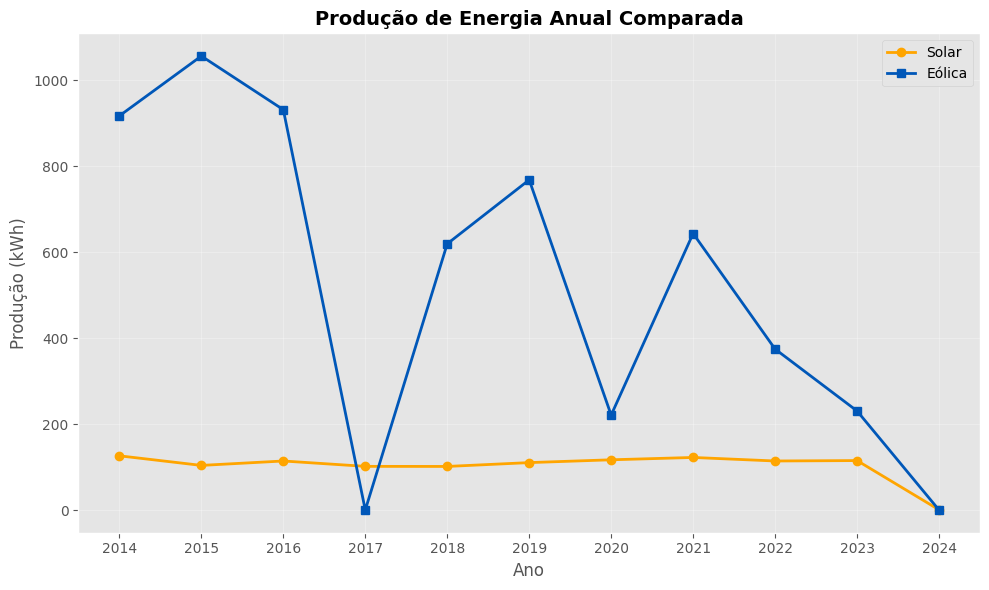

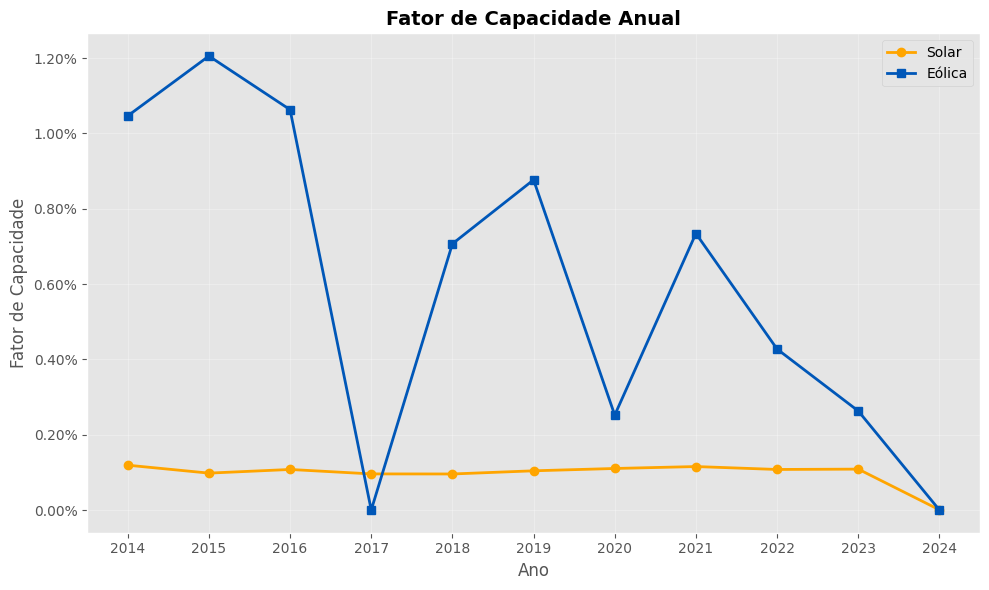

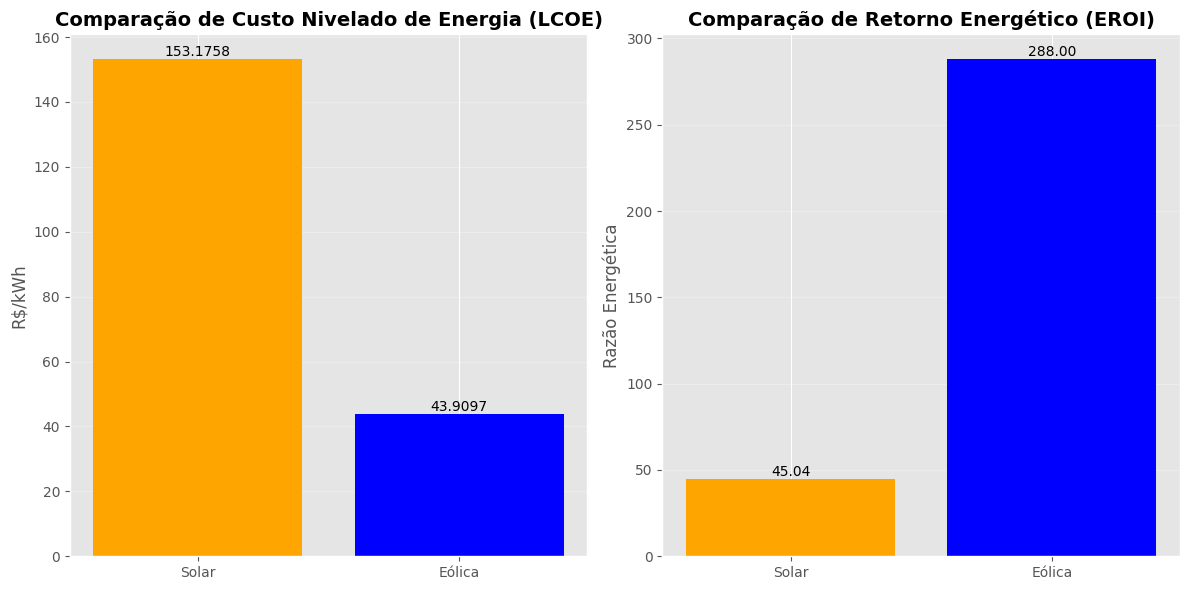


=== Resultados Comparativos ===
                          | Solar           | Eólica         
------------------------------------------------------------
Produção Total (kWh)      |        1,125.90 |        5,760.00
Fator de Capacidade Médio |           0.10% |           0.60%
LCOE (R$/kWh)             |        153.1758 |         43.9097
EROI                      |           45.04 |          288.00
Produção Média Anual (kWh) |          102.35 |          523.64


Recomendação: EÓLICA
Margem de vantagem: 65.7%

Detalhes:
- Menor custo: Eólica
- Melhor retorno: Eólica
- Maior eficiência operacional: Eólica


In [ ]:
# ---------------------------
# EXECUÇÃO PRINCIPAL
# ---------------------------

if __name__ == "__main__":
    # Parâmetros da região e período
    latitude = -23.5505  # Exemplo: São Paulo
    longitude = -46.6333
    #latitude = -12.8858426 # Exemplo: Salvador
    #longitude = -38.4149844
    start_date = "2014-01-01"
    end_date = "2024-01-01"
    timezone = "America/Sao_Paulo"

    # Coletar dados climáticos
    daily_data = search_info_weather(latitude, longitude, start_date, end_date, timezone)

    # Calcular fator de capacidade anual e média para energia solar
    producoes_anuais_solar, fatores_capacidade_anual_solar, media_producao_solar, media_fator_capacidade_solar = calcular_producao_e_fator_capacidade_anual(daily_data, "solar")

    # Calcular LCOE energia solar
    lcoe_solar = calcular_lcoe(
        PAINEL_SOLAR["custo_instalacao"],
        producoes_anuais_solar,
        PAINEL_SOLAR["vida_util"]
    )

    # Calcular fator de capacidade anual e média para energia eólica
    producoes_anuais_eolica, fatores_capacidade_anual_eolica, media_producao_eolica, media_fator_capacidade_eolica = calcular_producao_e_fator_capacidade_anual(daily_data, "eolica")

    # Calcular LCOE energia eólica
    lcoe_eolica = calcular_lcoe(
        TURBINA_EOLICA["custo_instalacao"],
        producoes_anuais_eolica,
        TURBINA_EOLICA["vida_util"]
    )

        # Calcular energia gasta para energia solar e eólica
    ENERGIA_GASTA_SOLAR = calcular_energia_gasta_solar()
    ENERGIA_GASTA_EOLICA = calcular_energia_gasta_eolica()

    # Calcular eroi para energia solar
    eroi_solar = calcular_eroi(producoes_anuais_solar, PAINEL_SOLAR["vida_util"], ENERGIA_GASTA_SOLAR)

    # Calcular eroi para energia eólica
    eroi_eolica = calcular_eroi(producoes_anuais_eolica, TURBINA_EOLICA["vida_util"], ENERGIA_GASTA_EOLICA)

    # Plotar gráficos
    gerar_graficos(producoes_anuais_solar, producoes_anuais_eolica,
               fatores_capacidade_anual_solar, fatores_capacidade_anual_eolica,
               lcoe_solar, lcoe_eolica,
               eroi_solar, eroi_eolica)

    # Exibir resultados
    exibir_resultados(
        producoes_anuais_solar,
        producoes_anuais_eolica,
        fatores_capacidade_anual_solar,
        fatores_capacidade_anual_eolica,
        media_producao_solar,
        media_producao_eolica,
        lcoe_solar,
        lcoe_eolica,
        eroi_solar,
        eroi_eolica
    )

    resultado = definir_melhor_energia(
    lcoe_solar,
    lcoe_eolica,
    eroi_solar,
    eroi_eolica,
    media_fator_capacidade_solar,
    media_fator_capacidade_eolica
    )

    print(f"\n")
    print(f"Recomendação: {resultado['recomendacao'].upper()}")
    print(f"Margem de vantagem: {resultado['margem']}")
    print("\nDetalhes:")
    print(f"- {resultado['detalhes']['lcoe']}")
    print(f"- {resultado['detalhes']['eroi']}")
    print(f"- {resultado['detalhes']['fc']}")